Use this notebook with the `smina` environment.

In [ ]:
import src.smina
import importlib
importlib.reload(src.smina)
from src.smina import read_pdb_with_ob, prepare_ob_mols, prepare_ob_mols, get_protein_ligand_idxs, save_trimmed_pdb

In [1]:
import sys
sys.path.append('..')

import nglview as ng 
import mdtraj 
import numpy as np 
import os 
from src.workshop_2_utils import *
from pathlib import Path

from config import settings

lab2_data_path = settings.data_path / "lab2"

smina_inputs_path = lab2_data_path / "smina_inputs"
smina_inputs_path.mkdir(exist_ok=True)
smina_outputs_path = lab2_data_path / "smina_outputs"
smina_outputs_path.mkdir(exist_ok=True)

outputs_path = lab2_data_path / "outputs"
outputs_path.mkdir(exist_ok=True)

protein_ligand_pdb_file = lab2_data_path / "6vhn.pdb"
prepared_protein_pdb_file = lab2_data_path / "6vhn_prepared.pdb"

all_ligands_sdf_file = lab2_data_path / "Enamine_Hinge_Binders_Library_plated_24000cmds_20210316 (1).sdf"


In [2]:
traj = mdtraj.load(protein_ligand_pdb_file)


receptor, ligand = get_protein_ligand_idxs(traj)

ligand_pdb_file = lab2_data_path / "ligand.pdb"
save_trimmed_pdb(ligand_pdb_file, traj,ligand)
#save_trimmed_pdb(lab2_data_path / "receptor.pdb", traj,receptor)



In [3]:
ligand_mol= read_pdb_with_ob(ligand_pdb_file)


*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this serial number.
  THIS CONECT RECORD WILL BE IGNORED.

*** Open Babel Warning  in parseConectRecord
  Problems reading a CONECT record.
  According to the PDB specification,
  columns 7-11 should contain the serial number of an atom.
  No atom was found with this se

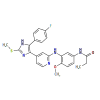

In [4]:
ligand_mol[0]

In [5]:
ligand_pdbqt_path = smina_inputs_path / "ligand.pdbqt"
prepare_ob_mols(ligand_mol[0], str(), overwrite=True)

In [6]:
protein_pdbqt_file = smina_inputs_path / "receptor.pdbqt"

prep=Preprocessor()
prep.prepare_receptor(prepared_protein_pdb_file, protein_pdbqt_file)
#prep.prepare_ligand("data/ligand.pdb", "smina_inputs/ligand.pdbqt", in_format="pdb")

In [7]:
# Binding box creations

In [8]:
ligand=mdtraj.load(ligand_pdb_file)
def create_box_from_ligand(ligand):
    xyz=ligand.xyz[0]*10 # convert to Angstrom from nm
    pocket_center = (xyz.max(axis=0) + xyz.min(axis=0)) / 2
    pocket_size = xyz.max(axis=0) - xyz.min(axis=0) + 5
    return Box.from_array(pocket_center, pocket_size)

box=create_box_from_ligand(ligand)
box

Box(center=Point(x=-51.568, y=0.7765, z=23.5065), size=Point(x=11.748001, y=12.989, z=17.699))

In [9]:
from src.workshop_2_utils import Docking 
    
docker=Docking(protein_pdbqt_file, box) 
        

In [10]:
ligand_docked_path = lab2_data_path / "outputs/ligand_out.sdf"

text=docker.dock_one(ligand_pdbqt_path, ligand_docked_path)
docker.parse_output(text)

,affinity,rmsd_lb,rmsd_ub
0,-9.6,0.000,0.000
1,-8.9,2.998,5.788
2,-8.6,3.313,7.931
3,-8.2,2.770,5.320
4,-8.1,3.565,6.205


In [11]:

poses=dm.read_sdf(ligand_docked_path, as_df=True, mol_column="mols", n_jobs=-1)
poses

,smiles,mols,minimizedAffinity
0,[C][C]C(=O)Nc1[c][c]c(O[C])c(Nc2[c]c(-c3nc(S[C...,<rdkit.Chem.rdchem.Mol object at 0x7fb6a83a7ed0>,-9.557410
1,[C][C]C(=O)Nc1[c][c]c(O[C])c(Nc2[c]c(-c3nc(S[C...,<rdkit.Chem.rdchem.Mol object at 0x7fb625ad03c0>,-8.881706
2,[C][C]C(=O)Nc1[c][c]c(O[C])c(Nc2[c]c(-c3nc(S[C...,<rdkit.Chem.rdchem.Mol object at 0x7fb625ad0510>,-8.631896
3,[C][C]C(=O)Nc1[c][c]c(O[C])c(Nc2[c]c(-c3nc(S[C...,<rdkit.Chem.rdchem.Mol object at 0x7fb625ad0580>,-8.155849
4,[C][C]C(=O)Nc1[c][c]c(O[C])c(Nc2[c]c(-c3nc(S[C...,<rdkit.Chem.rdchem.Mol object at 0x7fb625ad05f0>,-8.106444


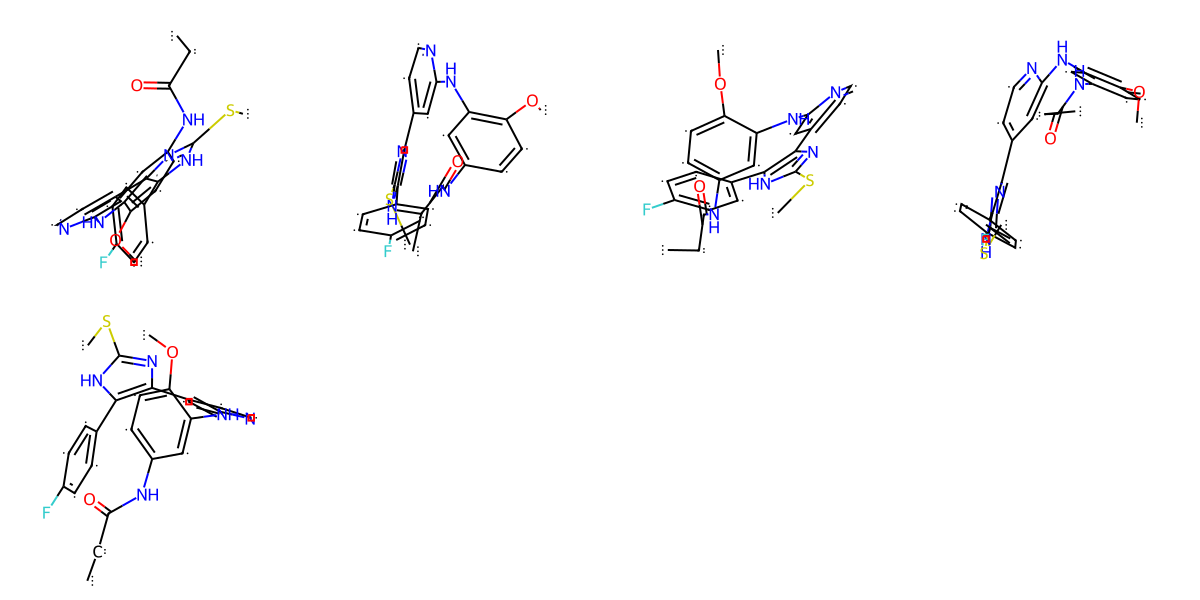

In [12]:
dm.viz.to_image(poses["mols"])

In [13]:
# Now for some real molecules 

In [14]:
import datamol as dm 
df_mols = dm.read_sdf(all_ligands_sdf_file, as_df=True, mol_column="mols", n_jobs=-1)
docker.parse_mol_to_pbdqt(df_mols["mols"][0], out_dir = smina_inputs_path)



In [15]:
text=docker.dock_one(smina_inputs_path / "mol_0.pdbqt", outputs_path / "poses_0.sdf")
docker.parse_output(text)
poses=dm.read_sdf(outputs_path / "poses_0.sdf", as_df=True, mol_column="mols", n_jobs=-1)
poses

,smiles,mols,minimizedAffinity
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0d700>,-6.002171
1,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0d460>,-5.916320
2,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0d3f0>,-5.689765
3,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0d620>,-5.511173
4,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0d690>,-5.445851


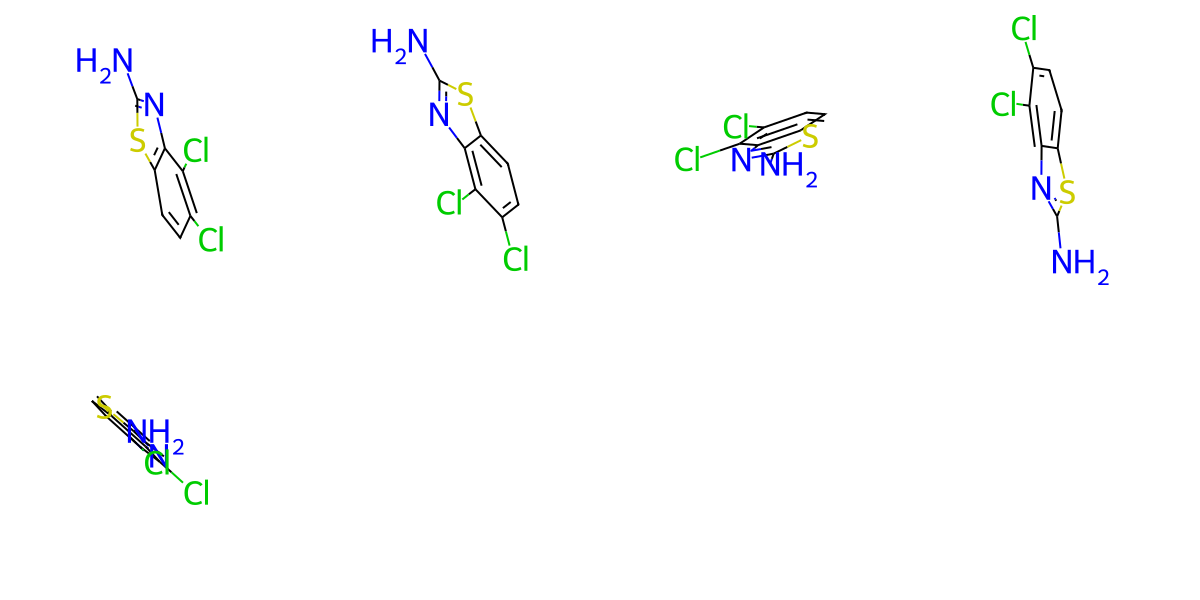

In [16]:
dm.viz.to_image(poses["mols"])

In [17]:
df_mols.head()

,smiles,mols,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a420>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a5e0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a6c0>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a730>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a7a0>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3


In [18]:
df_mols["fp"]=df_mols["mols"].apply(lambda x : dm.to_fp(x))
df_mols

,smiles,mols,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,fp
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a420>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a5e0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a6c0>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a730>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a7a0>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
23995,CC(C)(C)OC(=O)c1cc2c(NCC(c3cccc(F)c3)N3CCOCC3)...,<rdkit.Chem.rdchem.Mol object at 0x7fb6bd1184a0>,Z4635150192,1252574-R-291,F11,441.499,4.305,2,92.37,8,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23996,COC(=O)c1cc2c(NC3CCCc4cc(OC)ccc4C3)ncnc2[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bd118510>,Z4635150292,1252574-R-291,B10,366.414,4.276,2,89.13,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23997,CSc1ccc2c(c1)C(Nc1ncnc3ccc(Br)cc13)CCO2,<rdkit.Chem.rdchem.Mol object at 0x7fb6bd118580>,Z4635150411,1252574-R-278,D05,402.308,4.688,1,47.04,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23998,CCc1c[nH]c2ncnc(NCc3cccc(CN4CCCC(C(N)=O)C4)c3)c12,<rdkit.Chem.rdchem.Mol object at 0x7fb6bd1185f0>,Z4636144292,1252574-R-279,C02,392.497,3.197,3,99.93,7,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
docker=Docking(protein_pdbqt_file, box) 

In [22]:
docker.dock_multiple_mols(
        df_mols["mols"].tolist()[:5],
        input_dir = smina_inputs_path,
        output_dir = smina_outputs_path,
        idxs= list(range(5)),
)


2024-06-20 16:34:25.597 | INFO     | src.workshop_2_utils:dock_multiple_mols:266 - Converting mols to pdbqt in 'smina_inputs' folder
2024-06-20 16:34:25.609 | INFO     | src.workshop_2_utils:dock_multiple_mols:270 - Docking
100%|██████████| 5/5 [00:09<00:00,  1.84s/it]
2024-06-20 16:34:34.812 | INFO     | src.workshop_2_utils:dock_multiple_mols:275 - Merge all the generated poses together to /home/ubuntu/smina/ml4dd/data/lab2/smina_outputs


In [23]:
poses= dm.read_sdf(smina_outputs_path / "poses.sdf", as_df=True, mol_column="mols", n_jobs=-1)
poses.sort_values("minimizedAffinity",inplace=True)
poses

,smiles,mols,minimizedAffinity
20,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0e6c0>,-6.285374
45,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0fa00>,-6.268059
5,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0eea0>,-6.238235
30,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0da80>,-6.219009
6,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0ee30>,-6.159406
7,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0edc0>,-6.151715
31,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0da10>,-6.151686
8,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0ed50>,-6.148581
15,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0e960>,-5.994373
40,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb6bcc0e030>,-5.922511


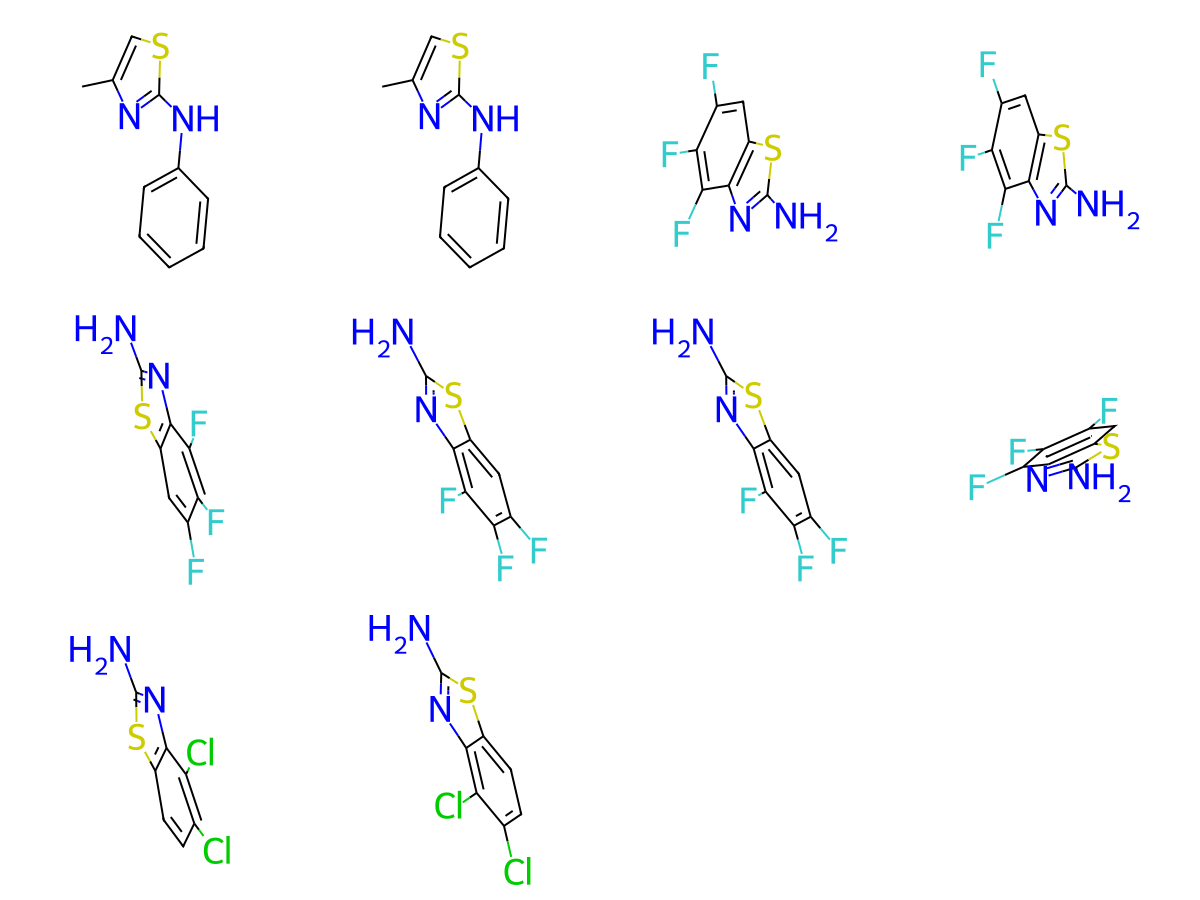

In [24]:
dm.viz.to_image(poses["mols"].tolist()[:10])

In [25]:
def get_random_idxs(df, n=10, seed=42):
    np.random.seed(seed)
    return np.random.randint(0, len(df), n)


df = init_df_fields(df_mols)
df.head()

,smiles,mols,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,fp,idxs,pred_affinity,uncertainty,true_affinity,sampled
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a420>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,NaN,NaN,NaN,0
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a5e0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1,NaN,NaN,NaN,0
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a6c0>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,NaN,NaN,NaN,0
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a730>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,NaN,NaN,NaN,0
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x7fb622b3a7a0>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,NaN,NaN,NaN,0


In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor

def train_gp(df) -> GaussianProcessRegressor:
    from sklearn.gaussian_process.kernels import RBF
    X = np.vstack(df["fp"][df["sampled"]>=1].tolist())
    Y = np.vstack(df["true_affinity"][df["sampled"]>=1].tolist())
    return GaussianProcessRegressor(kernel=RBF(length_scale=2.0,
                                               length_scale_bounds=(1e-1, 20.0)),
                                     random_state=0).fit(X,Y)

def predict_with_gp(df, gp):
    X = np.vstack(df["fp"].tolist())
    Y = np.vstack(df["true_affinity"].tolist())
    mean, std = gp.predict(X, return_std=True)
    df["pred_affinity"] = mean
    df["uncertainty"] = std
    return df

def samples_next(df, n: int = 10, sort_by_uncertainty = True) -> List[int]:
    original_df = df
    if sort_by_uncertainty:
        ascending=False
        name="uncertainty"
    else:
        ascending=True
        name="pred_affinity"
    return df.sort_values(name, ascending=ascending)["idxs"].tolist()[:n]



#gp=train_gp(df_mols_al)
#df = predict_with_gp(df, gp)
#df.head()

In [27]:
def get_results(output_dir, idxs):
    values=[]
    key="minimizedAffinity"
    for idx in idxs:
        poses= dm.read_sdf(os.path.join(output_dir, f"poses_{idx}.sdf"), as_df=True, mol_column="mols", n_jobs=-1, sanitize=False)
        poses=poses.sort_values("minimizedAffinity",inplace=False)
        values.append(poses["minimizedAffinity"][0])
    return values

def format_df(df, affinities, sampled_idxs, iteration):
    df["true_affinity"][sampled_idxs]=affinities
    df["sampled"][sampled_idxs]=iteration
    return df

In [30]:
from copy import deepcopy

N_OF_AL_ITERATIONS = 5
AL_ON_UNCERTAINTY = True
FIRST_LOOP=True # get random idxs at the first loop
N_OF_ORACLE_CALLS=3 # n of samples for initialization
SEED = 42

docker=Docking(lab2_data_path / "smina_inputs/receptor.pdbqt", box, num_poses=3)

ultimate_df = deepcopy(df)
for iteration in range(N_OF_AL_ITERATIONS):
    if FIRST_LOOP:
        FIRST_LOOP = not FIRST_LOOP
        sampled_idxs= get_random_idxs(ultimate_df, n=N_OF_ORACLE_CALLS, seed=SEED).tolist()

    # Create iteration directory
    output_dir = lab2_data_path  / f"al_loop_{iteration}"
    input_dir = lab2_data_path / "smina_inputs"
    os.makedirs(output_dir,exist_ok=True)

    # Select molecules to dock and dock them
    # really slow on colab
    mols_to_dock=ultimate_df["mols"].to_numpy()[sampled_idxs]
    docker.dock_multiple_mols(mols_to_dock, input_dir, output_dir, sampled_idxs)

    # Get results
    affinities = get_results(output_dir, sampled_idxs)
    ultimate_df = format_df(ultimate_df, affinities, sampled_idxs, iteration + 1)

    # AL call
    GP = train_gp(ultimate_df)
    ultimate_df = predict_with_gp(ultimate_df, GP)
    sampled_idxs = samples_next(ultimate_df, N_OF_ORACLE_CALLS, AL_ON_UNCERTAINTY)




2024-06-20 16:35:39.312 | INFO     | src.workshop_2_utils:dock_multiple_mols:266 - Converting mols to pdbqt in 'smina_inputs' folder
2024-06-20 16:35:39.321 | INFO     | src.workshop_2_utils:dock_multiple_mols:270 - Docking
100%|██████████| 3/3 [00:47<00:00, 15.88s/it]
2024-06-20 16:36:26.950 | INFO     | src.workshop_2_utils:dock_multiple_mols:275 - Merge all the generated poses together to /home/ubuntu/smina/ml4dd/data/lab2/smina_inputs


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/smina/ml4dd/data/lab2/al_loop_0/poses_23654.sdf'